# Building Agents 

We're going to build an email assistant from scratch, starting here with 1) the agent architecture (using [LangGraph](https://langchain-ai.github.io/langgraph/)) and following with 2) testing (using [LangSmith](https://docs.smith.langchain.com/)), 3) human-in-the-loop, and 4) memory. This diagram show how these pieces will fit together:
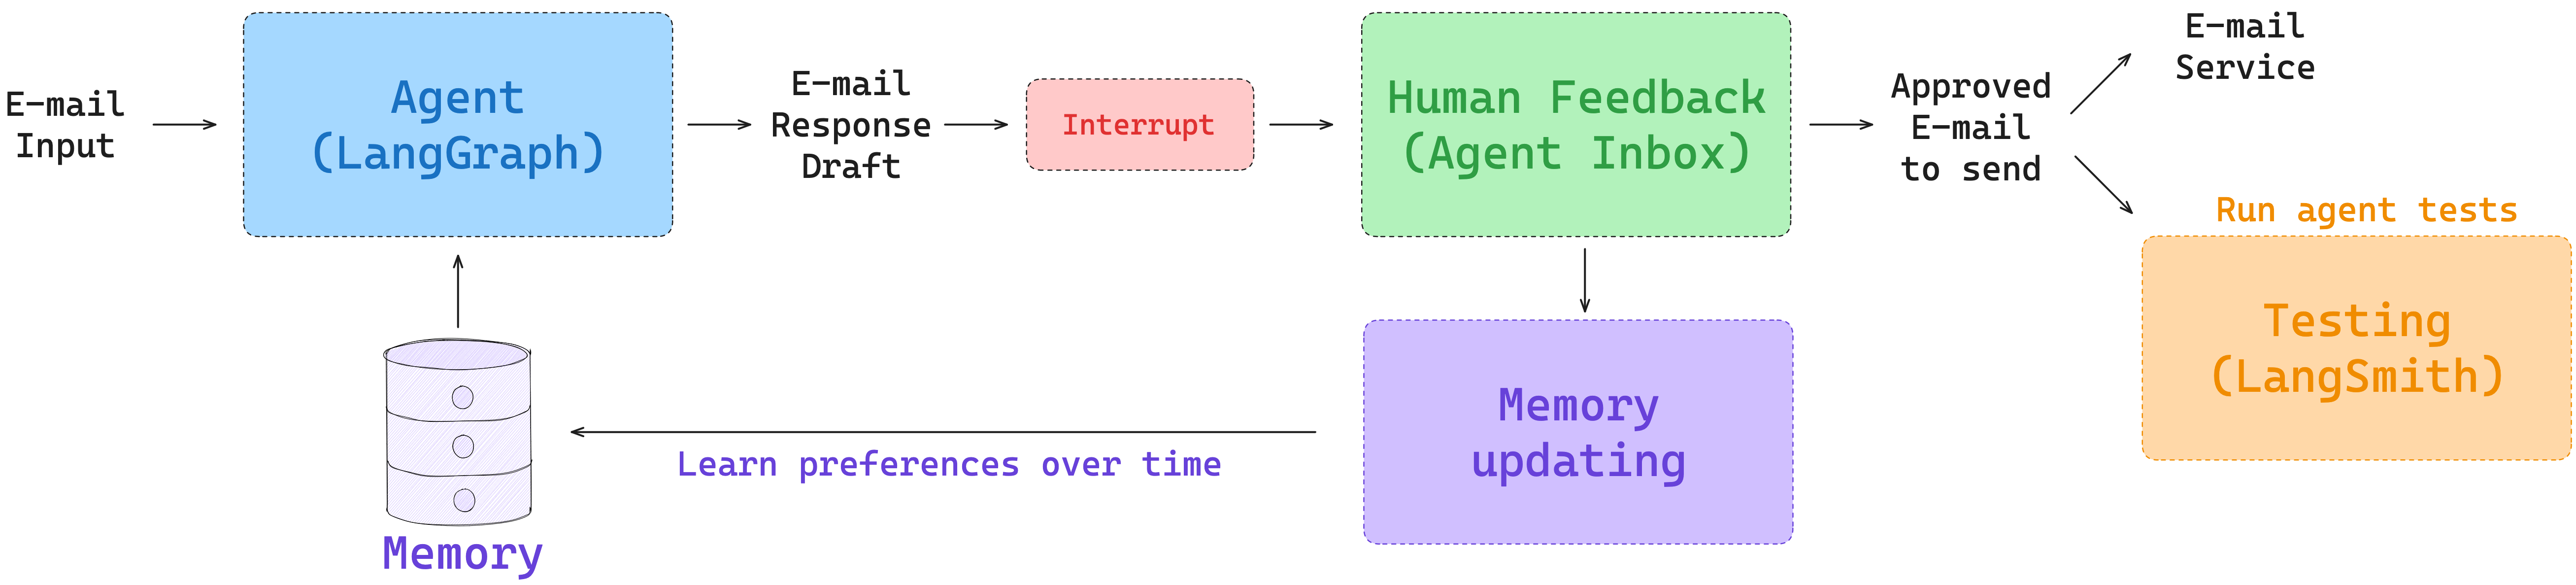

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

## Tool Definition

Let's start by defining some simple tools that an email assistant will use with the `@tool` decorator:

In [2]:
from typing import Literal
from datetime import datetime 
from pydantic import BaseModel
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send and email."""
    # Placeholder response - in real app will send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B, %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
def Done(BaseModel):
    """E-mail has been sent."""
    done: bool


## Building our email assistant

We'll combine a [router and agent](https://langchain-ai.github.io/langgraph/tutorials/workflows/) to build our email assistant.

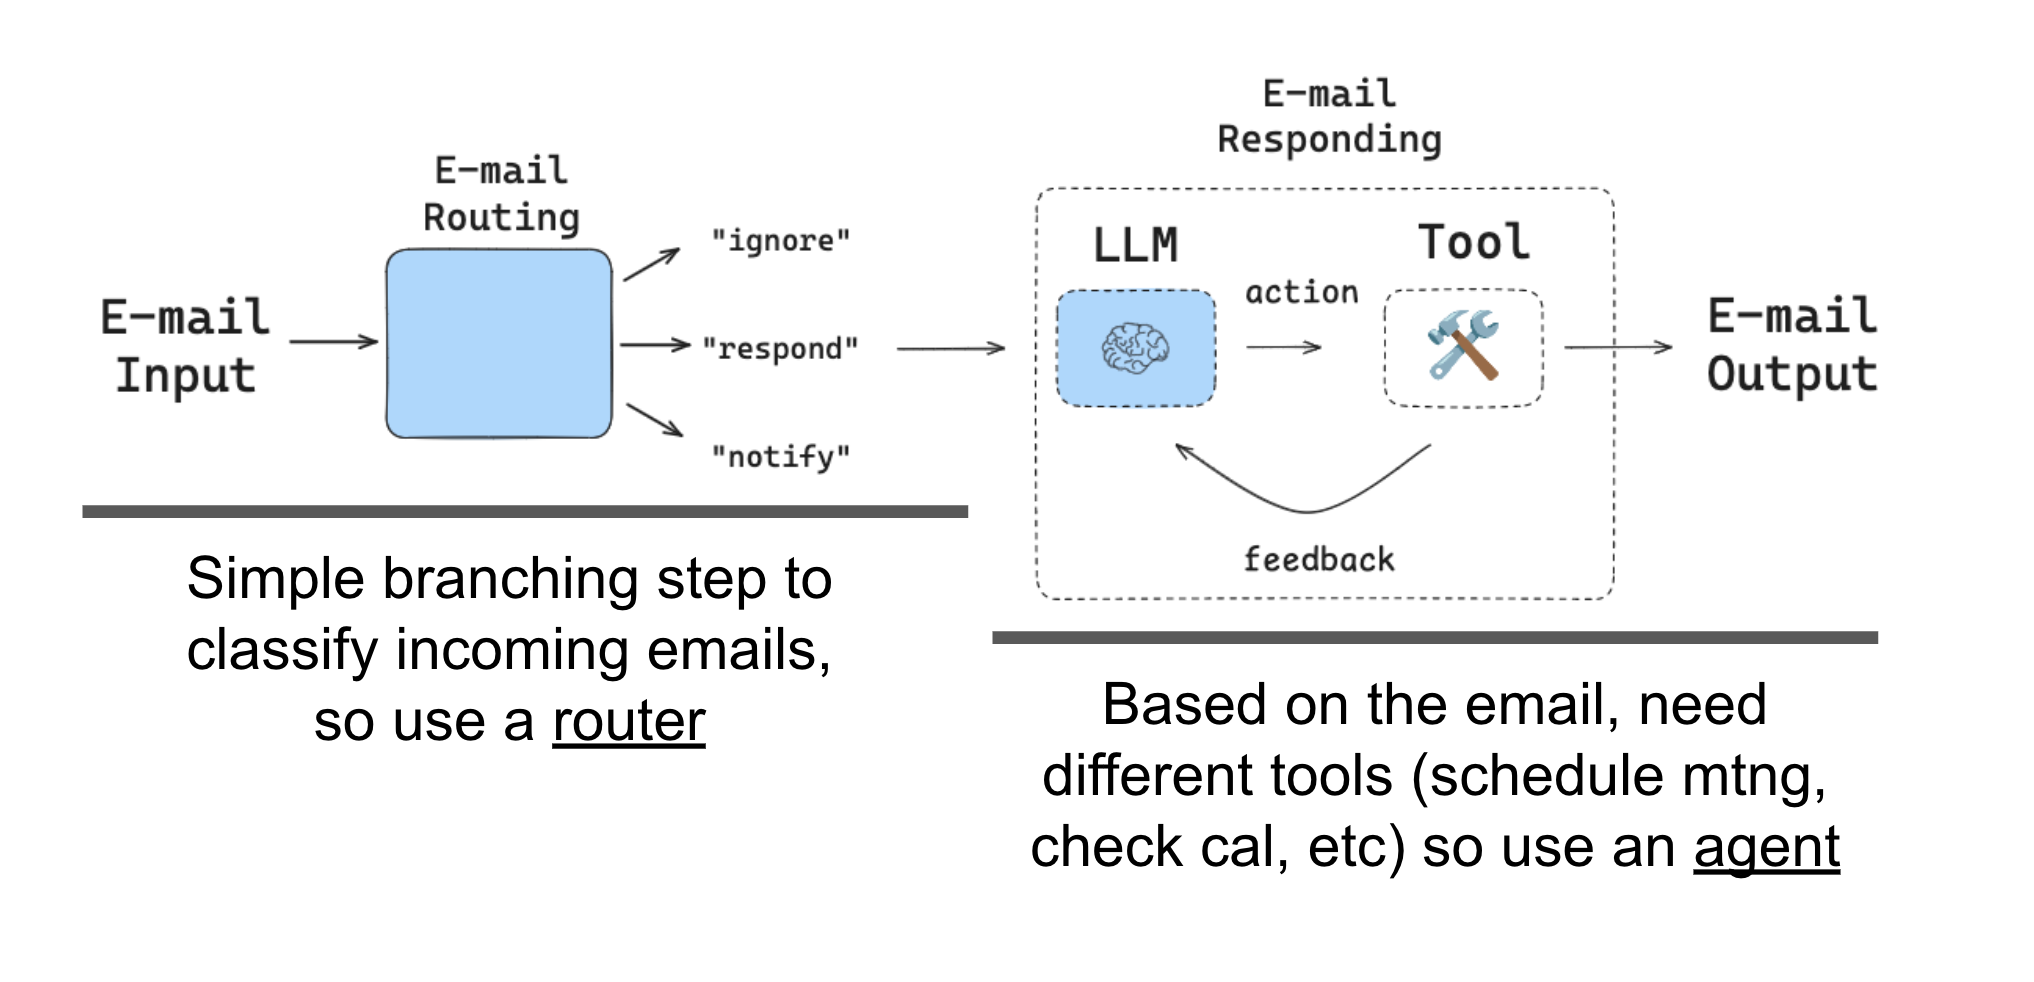

### Router

The routing step handles the triage decision. 

The triage router only focuses on the triage decision, while the agent focuses *only* on the response. 

#### State

When building an agent, it's important to consider the information that you want to track over time. We'll use LangGraph's pre-built [`MessagesState` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate), which is a just dictionary with a `messages` key that appends messages returned by nodes [as its update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). However, LangGraph gives you flexibility to track other information. We'll define a custom `State` object that extends `MessagesState` and adds a `classification_decision` key:

In [5]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # We can add specific key to our state for the email input
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

#### Triage node

We define a python function with our triage routing logic.

For this, we use [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) with a Pydantic model, which is particularly useful for defining structured output schemas because it offers type hints and validation. The descriptions in the pydantic model are important because they get passed as part JSON schema to the LLM to inform the output coercion.

In [45]:
%load_ext autoreload
%autoreload 2

from pydantic import BaseModel, Field
from email_assistant.utils import parse_email, format_email_markdown
from email_assistant.prompts import triage_system_prompt, triage_user_prompt, default_triage_instructions, default_background
from langchain.chat_models import init_chat_model
from langgraph.graph import END
from langgraph.types import Command

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from rich.markdown import Markdown
Markdown(triage_system_prompt)

< Role > Your role is to triage incoming emails based upon instructs and background information below. </ Role >   

< Background > {background}. </ Background >                                                                       

< Instructions > Categorize each email into one of three categories:                                               

 1 IGNORE - Emails that are not worth responding to or tracking                                                    
 2 NOTIFY - Important information that worth notification but doesn't require a response                           
 3 RESPOND - Emails that need a direct response Classify the below email into one of these categories. </          
   Instructions >                                                                                                  

< Rules > {triage_instructions} </ Rules >

In [12]:
Markdown(triage_user_prompt)

Please determine how to handle the below email thread:                                                             

From: {author} To: {to} Subject: {subject} {email_thread}

In [13]:
Markdown(default_background)

I'm Jai Keshav Sharma, an AI Engineer at Meta AI.

In [8]:
Markdown(default_triage_instructions)

Emails that are not worth responding to:                                                                           

 • Marketing newsletters and promotional emails                                                                    
 • Spam or suspicious emails                                                                                       
 • CC'd on FYI threads with no direct questions                                                                    

There are also other things that should be known about, but don't require an email response. For these, you should 
notify (using the notify response). Examples of this include:                                                      

 • Team member out sick or on vacation                                                                             
 • Build system notifications or deployments                                                                       
 • Project status updates without action items                                                                     
 • Important company announcements                                                                                 
 • FYI emails that contain relevant information for current projects                                               
 • HR Department deadline reminders                                                                                
 • Subscription status / renewal reminders                                                                         
 • GitHub notifications                                                                                            

Emails that are worth responding to:                                                                               

 • Direct questions from team members requiring expertise                                                          
 • Meeting requests requiring confirmation                                                                         
 • Critical bug reports related to team's projects                                                                 
 • Requests from management requiring acknowledgment                                                               
 • Client inquiries about project status or features                                                               
 • Technical questions about documentation, code, or APIs (especially questions about missing endpoints or         
   features)                                                                                                       
 • Personal reminders related to family (wife / daughter)                                                          
 • Personal reminder related to self-care (doctor appointments, etc)

In [31]:
class RouterSchema(BaseModel):
    """Analyse the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'igonre' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply"
    )

# Initialise the LLM for use with router / structured output 
llm = init_chat_model(model="groq:qwen/qwen3-32b", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema)

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify or ignore."""

    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        background=default_background, 
        triage_instructions=default_triage_instructions
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt}, 
            {"role": "user", "content": user_prompt}
        ]
    )

    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user", 
                    "content": f"Respond to this email: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                }
            ],
            "classification_decision": result.classification
        }

    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        goto = END
        update = {
            "classification_decision": result.classification, 
        }

    elif result.classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
        goto = END
        update = {
            "classification_decision": result.classification,
        }

    else:
        raise ValueError(f"Invalid classification: {result.classification}")

    return Command(goto=goto, update=update)

We use [Command](https://langchain-ai.github.io/langgraph/how-tos/command/) objects in LangGraph to both update the state and select the next node to visit. This is a useful alternative to edges.

### Agent

Now, let's build the agent.

#### LLM node

Here, we define the LLM decision-making node. This node takes in the current state, calls the LLM, and updates `messages` with the LLM output. 

We [enforce tool use with OpenAI](https://python.langchain.com/docs/how_to/tool_choice/) by setting `tool_choice="required"`.

In [32]:
from email_assistant.tools.default.prompt_templates import AGENT_TOOLS_PROMPT
from email_assistant.prompts import agent_system_prompt, default_response_preferences, default_cal_preferences

In [33]:
Markdown(AGENT_TOOLS_PROMPT)

 1 write_email(to, subject, content) - Send emails to specified recipients                                         
 2 schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings  
   where preferred_day is a datetime object                                                                        
 3 check_calendar_availability(day) - Check available time slots for a given day                                   
 4 Done - E-mail has been sent

In [34]:
Markdown(agent_system_prompt)

< Role > You are a top-notch executive assistant who cares about helping your executive perform as well as         
possible. </ Role >                                                                                                

< Tools > You have access to the following tools to help manage communications and schedule: {tools_prompt} </     
Tools >                                                                                                            

< Instructions > When handling emails, follow these steps:                                                         

 1 Carefully analyze the email content and purpose                                                                 
 2 IMPORTANT --- always call a tool and call one tool at a time until the task is complete:                        
 3 For responding to the email, draft a response email with the write_email tool                                   
 4 For meeting requests, use the check_calendar_availability tool to find open time slots                          
 5 To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter     
    • Today's date is 2025-10-08 - use this for scheduling meetings accurately                                     
 6 If you scheduled a meeting, then draft a short response email using the write_email tool                        
 7 After using the write_email tool, the task is complete                                                          
 8 If you have sent the email, then use the Done tool to indicate that the task is complete </ Instructions >      

< Background > {background} </ Background >                                                                        

< Response Preferences > {response_preferences} </ Response Preferences >                                          

< Calendar Preferences > {cal_preferences} </ Calendar Preferences >

In [35]:
tools = [write_email, schedule_meeting, check_calendar_availability, Done]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM, enforcing tool use
llm = init_chat_model(model="groq:qwen/qwen3-32b", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

def llm_call(state: State):
    """LLM decides whether to call a tool or not."""

    return {
        "messages": [
            # invoke the llm
            llm_with_tools.invoke(
                # Add the system prompt
                [
                    {"role": "system", "content": agent_system_prompt.format(
                        tools_prompt=AGENT_TOOLS_PROMPT,
                        background=default_background,
                        response_preferences=default_response_preferences,
                        cal_preferences=default_cal_preferences,
                    )}
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )
        ]
    }

#### Tool handler node

After the LLM makes a decision, we need to execute the chosen tool. 

The `tool_handler` node executes the tool. We can see that nodes can update the graph state to capture any important state changes, such as the classification decision.

In [36]:
def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []

    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})

    # Add it to our messages
    return {"messages": result}

#### Conditional Routing

Our agent needs to decide when to continue using tools and when to stop. This conditional routing function directs the agent to either continue or terminate.

In [37]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool is called."""

    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

#### Agent Graph

Finally, we can assemble all components:

In [38]:
from langgraph.graph import StateGraph, START, END
from email_assistant.utils import show_graph

# Build workflow 
overall_workflow = StateGraph(State)

# Add nodes 
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges 
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges("llm_call", should_continue, {"tool_handler": "tool_handler", END: END})
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

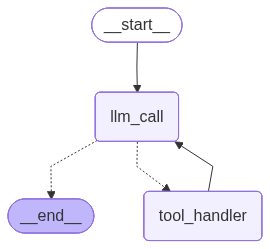

In [39]:
show_graph(agent)

In [40]:
overall_workflow = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

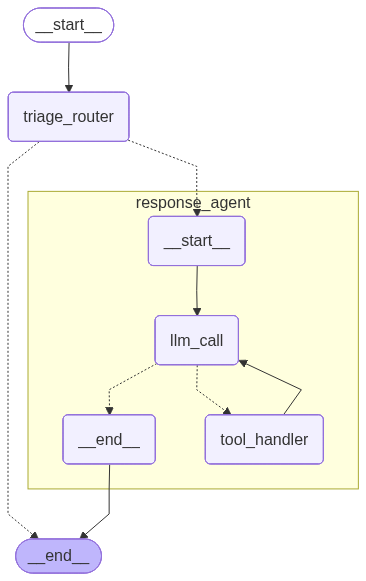

In [41]:
show_graph(overall_workflow, xray=True)

This is a higher-level composition where:
1. First, the triage router analyzes the email
2. If needed, the response agent handles crafting a response
3. The workflow ends when either the triage decides no response is needed or the response agent completes

In [42]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

🔔 Classification: NOTIFY - This email contains important information


In [43]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to this email: 



**Subject**: Quick question about API documentation
**From**: Alice Smith <alice.smith@company.com>
**To**: John Doe <john.doe@company.com>

Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice

---

================================== Ai Message ==================================
Tool Calls:
  write_email (cm9eqjzfj)
 Call ID: cm9eqjzfj
  Args:
    content: Hi Alice,

Thanks for pointing this out. I'll verify the status of the /auth/refresh and /auth/validate endpoints in our documentation and get back to you by EOD Tuesday, 2025-10-10. This will help ensure our specs are accu

## Testing with Local Deployment

You can find the file for our agent in the `src/email_assistant` directory:

* `src/email_assistant/email_assistant.py`

You can test them locally in LangGraph Studio by running:

```
! langgraph dev
```

Example e-mail you can test:

In [ ]:
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

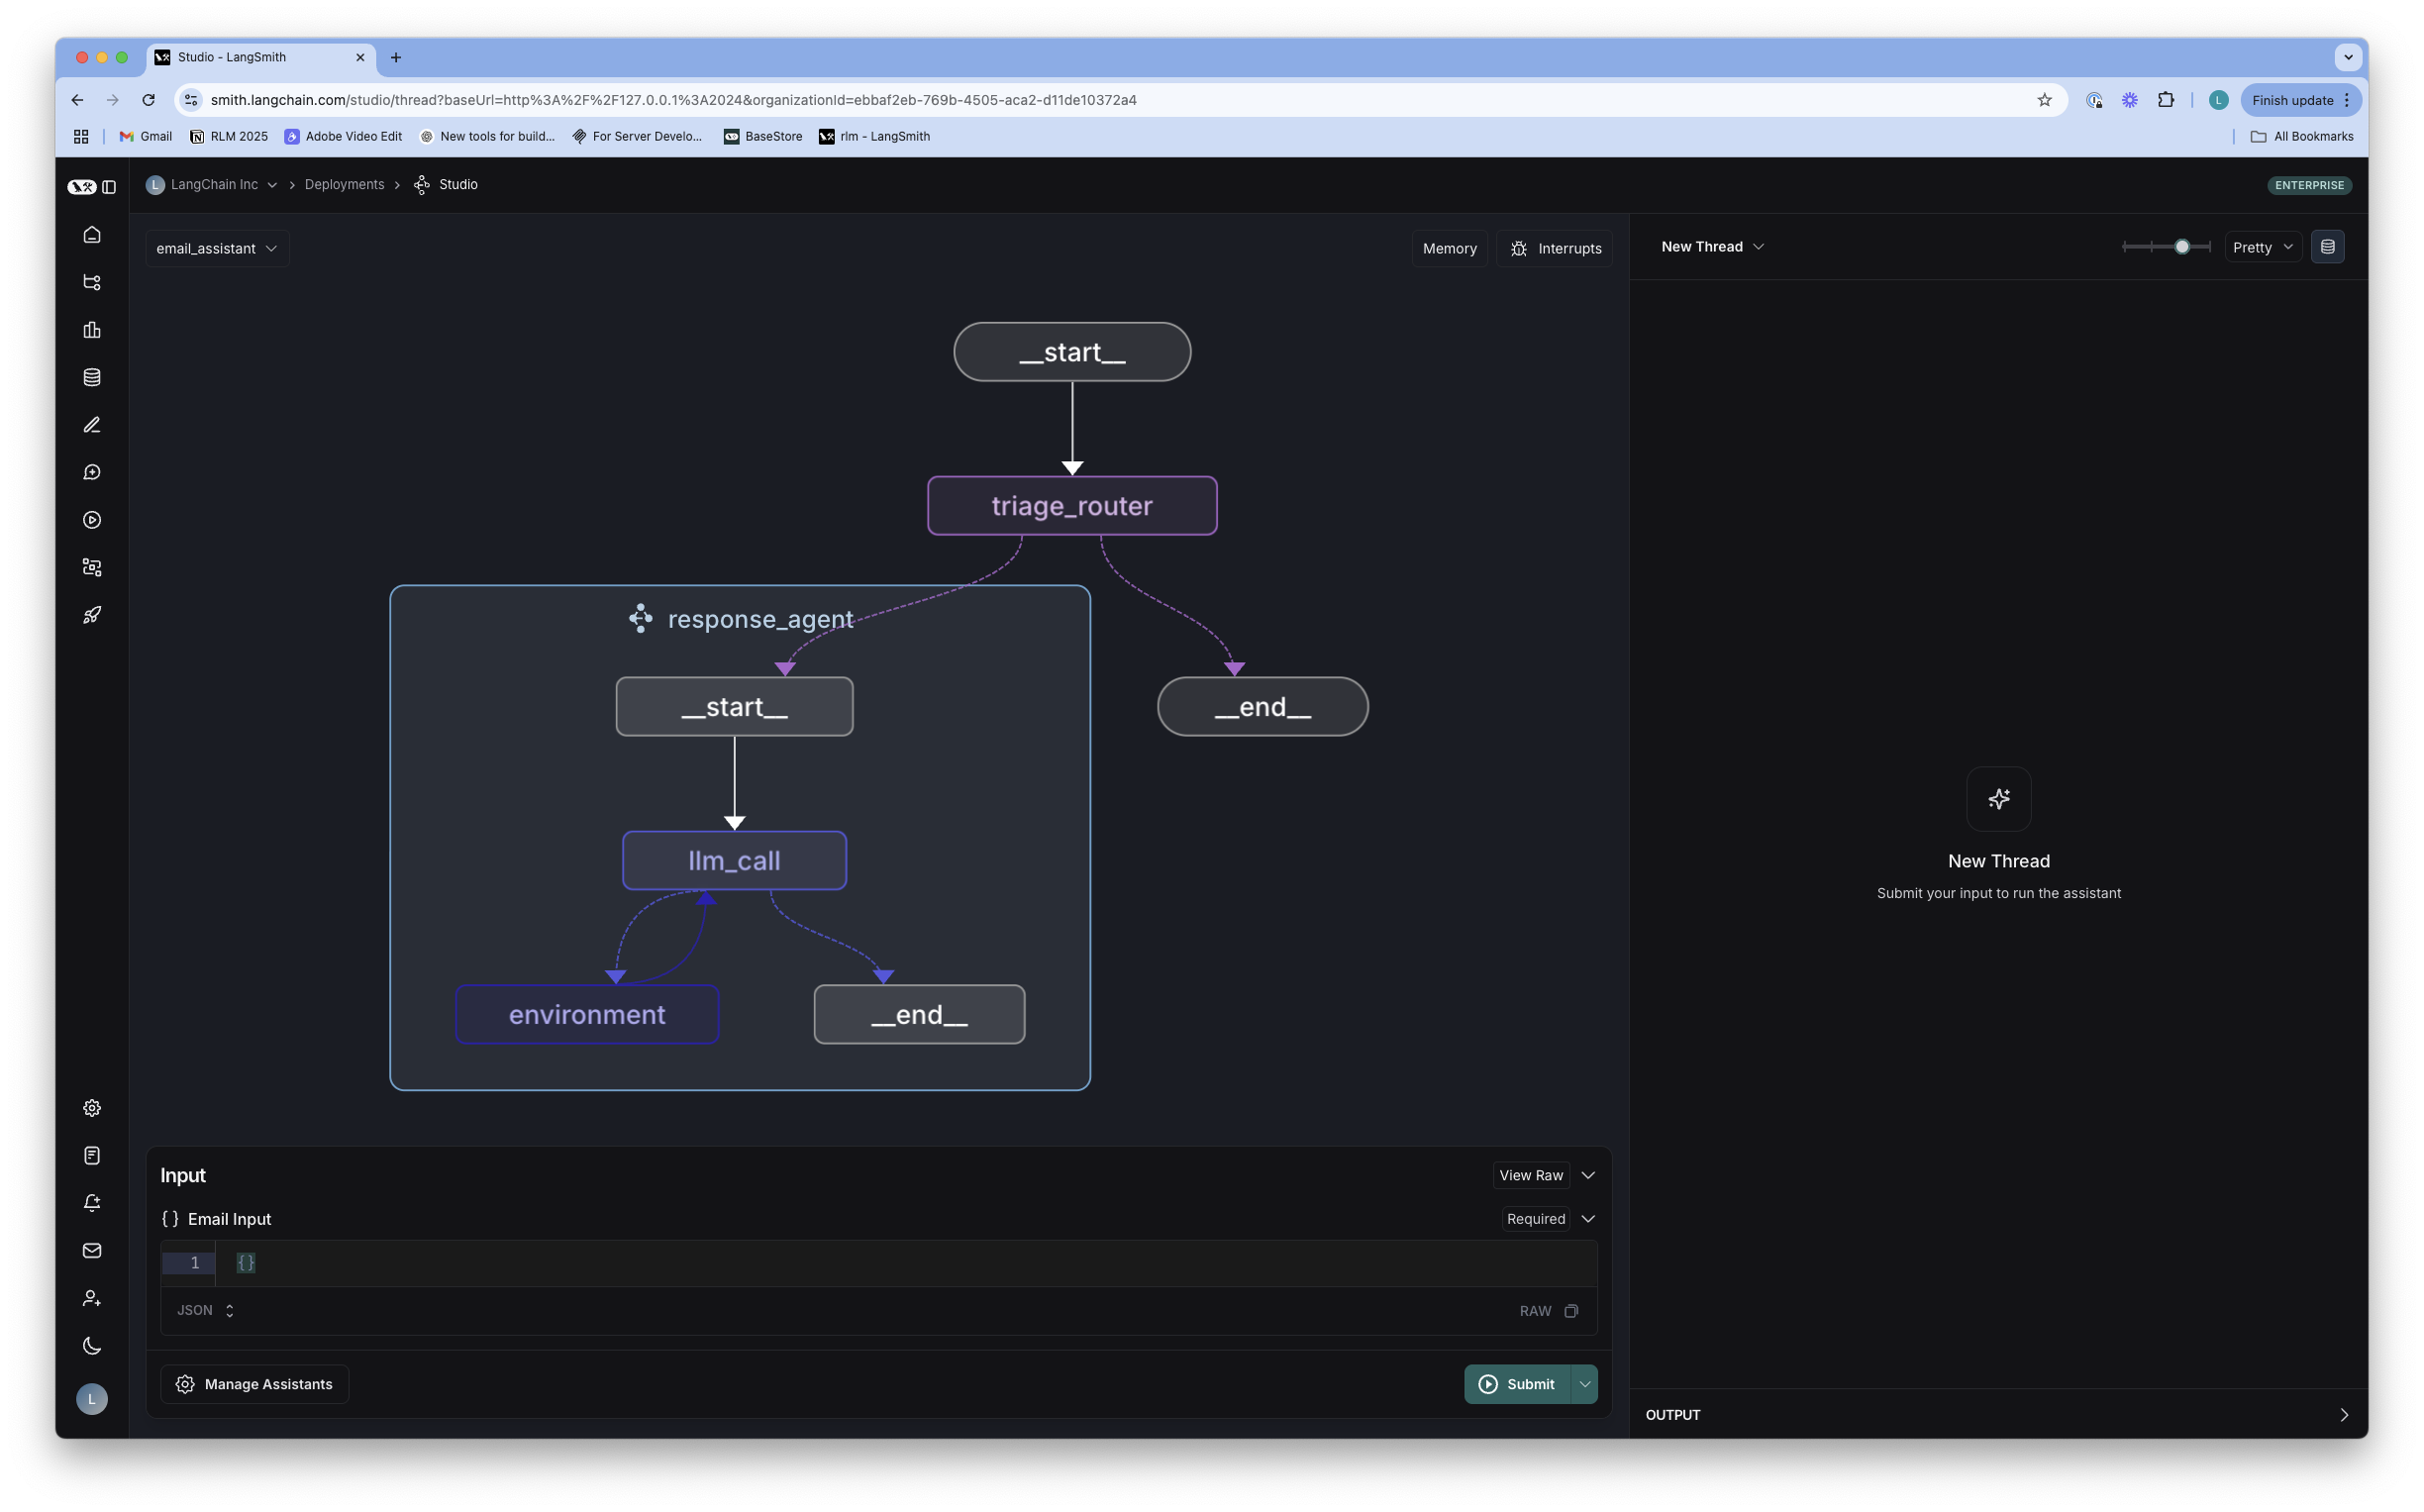